# Welcome to the Calibration Workshop!

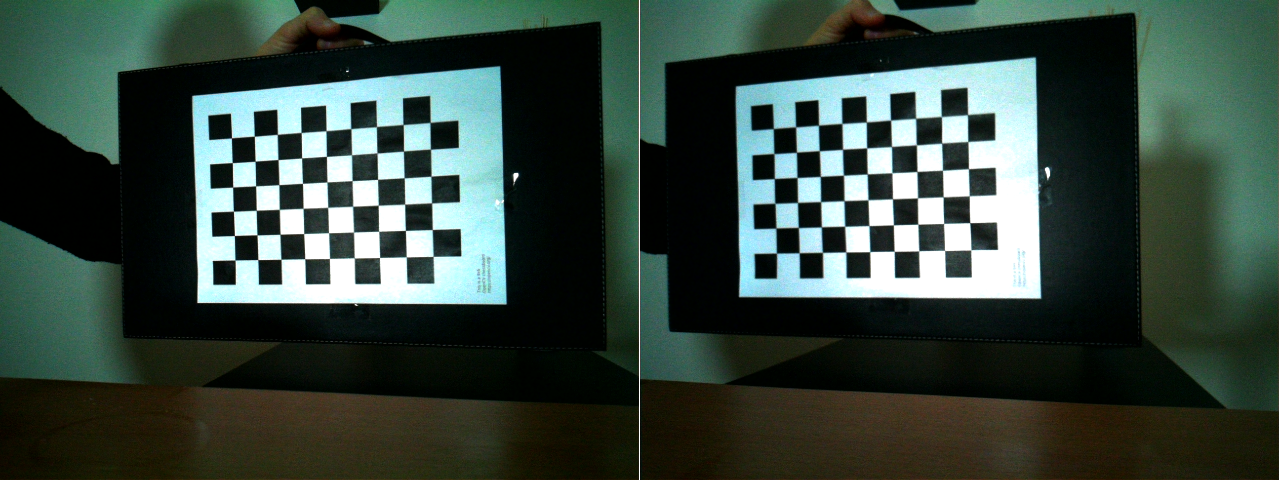

Today, we're going to learn how to calibrate a camera in mono and Stereo modes.

The outputs we're interested in:
*   The Focal length (intrinsic)
*   The Rotation Matrix (extrinsic)
*   The Translation Matrix (extrinsic)
*   The Optical Center (intrinsic)


In [12]:
from utils import extract_from_location, download_and_extract
import os

# Check if zip file exists, download if not
zip_file = "stereo_vision_data.zip"
if not os.path.exists(zip_file):
    print(f"{zip_file} not found. Downloading...")
    download_and_extract("https://stereo-vision.s3.eu-west-3.amazonaws.com/stereo_vision_data.zip")
else:
    print(f"{zip_file} found. Extracting...")
    extract_from_location(zip_file)

stereo_vision_data.zip not found. Downloading...
[==================================================] 100% (135956624/135956624 bytes)
Download complete: stereo_vision_data.zip
Extracting stereo_vision_data.zip...
Extraction complete to: .


In [13]:
# Dataset already extracted by the previous cell

In [14]:
import os

## Import Libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import os

# Step 1 - Mono Camera Calibration

Before going to stereo, it's good we try calibration with a monocular image.

👉 To go insanely faster, just check the OpenCV calibration tutorial and lines of code. Your work will be to understand how to adapt it here.

Open: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html



### First, go to the folder Image Pairs/pairs and only take the left (or the right) images

Found 30 left images


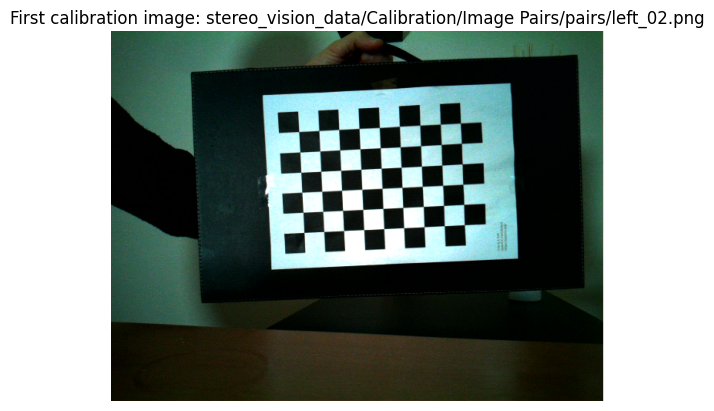

In [16]:
## TODO: Load the Left (or right) Images. You can use the GLOB API.

calibration_images = glob.glob("stereo_vision_data/Calibration/Image Pairs/pairs/left_*.png")
print(f"Found {len(calibration_images)} left images")

## TODO2: Show an image
if calibration_images:
    img = mpimg.imread(calibration_images[0])
    plt.imshow(img)
    plt.title(f"First calibration image: {calibration_images[0]}")
    plt.axis("off")
    plt.show()

Now, we'll need two things:
*   Object Points -- A matrix made of the dimensions of the chessboard with 3D coordinates (0,0,0) (0,1,0) ...
*   Image Points -- A matrix of 2D points with the same dimensions

In [17]:
# TODO: Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
## WARNING - The square size is 2.4 cm on my pictures.
rows = 6
columns = 9
square_size = 24 #expressed in mm

# Create a meshgrid of coordinates
objp = np.zeros((rows * columns, 3), np.float32)
objp[:, :2] = np.mgrid[0:columns, 0:rows].T.reshape(-1, 2)

# Scale by square_size to get actual measurements in mm
objp = objp * square_size

## TYPE OF OUTPUT WE'RE LOOKING FOR:
## [[  0.   0.   0.]
## [ 24.   0.   0.]
## [ 48.   0.   0.]
## ...
## [192. 120.   0.]]

## TODO2: Print the objp matrix and see if you have the same as I have
print(objp)

[[  0.   0.   0.]
 [ 24.   0.   0.]
 [ 48.   0.   0.]
 [ 72.   0.   0.]
 [ 96.   0.   0.]
 [120.   0.   0.]
 [144.   0.   0.]
 [168.   0.   0.]
 [192.   0.   0.]
 [  0.  24.   0.]
 [ 24.  24.   0.]
 [ 48.  24.   0.]
 [ 72.  24.   0.]
 [ 96.  24.   0.]
 [120.  24.   0.]
 [144.  24.   0.]
 [168.  24.   0.]
 [192.  24.   0.]
 [  0.  48.   0.]
 [ 24.  48.   0.]
 [ 48.  48.   0.]
 [ 72.  48.   0.]
 [ 96.  48.   0.]
 [120.  48.   0.]
 [144.  48.   0.]
 [168.  48.   0.]
 [192.  48.   0.]
 [  0.  72.   0.]
 [ 24.  72.   0.]
 [ 48.  72.   0.]
 [ 72.  72.   0.]
 [ 96.  72.   0.]
 [120.  72.   0.]
 [144.  72.   0.]
 [168.  72.   0.]
 [192.  72.   0.]
 [  0.  96.   0.]
 [ 24.  96.   0.]
 [ 48.  96.   0.]
 [ 72.  96.   0.]
 [ 96.  96.   0.]
 [120.  96.   0.]
 [144.  96.   0.]
 [168.  96.   0.]
 [192.  96.   0.]
 [  0. 120.   0.]
 [ 24. 120.   0.]
 [ 48. 120.   0.]
 [ 72. 120.   0.]
 [ 96. 120.   0.]
 [120. 120.   0.]
 [144. 120.   0.]
 [168. 120.   0.]
 [192. 120.   0.]]


Good!

### Time to use those OpenCV functions 😊

The process is the following:

*   Read the images in a loop
*   Convert them to grayscale
*   Find the Chessboard corners using the cv2.findChessboardCorners function
*   (Optional) Use cornerSubPix for petter precision
*   Draw the Chessboard corners and display all of them to check if your calibration was successful
*   Return the object points and the image points

In [18]:
# TODO: Define a get_points function that will do calibration.

def get_points(calibration_images, objp, rows=6, columns=9):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(calibration_images):
        image = cv2.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (columns, rows), None)

        if ret==True:
            # If found, add object points, image points. Draw the corners and visualize them
            objpoints.append(objp)
            
            # Refine corner positions for better accuracy
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            
            # Draw and display the corners
            cv2.drawChessboardCorners(image, (columns, rows), corners2, ret)
            cv2.imshow('Chessboard Corners', image)
            cv2.waitKey(500)
    
    return objpoints, imgpoints

###Now, define a function that will send your defined object point matrix and the images and return the filled matrices 3D/2D matrices.

**Print the results to see if it makes sense.**

In [19]:
## TODO: Call the get_points function
objpoints, imgpoints =get_points(calibration_images, objp, rows=6, columns=9)

## Print an example
print("An example of an object point (top-left corner) and its corresponding image point")
print(objpoints[0][0])
print(imgpoints[0][0])
cv2.destroyAllWindows()

An example of an object point (top-left corner) and its corresponding image point
[0. 0. 0.]
[[243.8612  130.59435]]


### Finally, call the cv2.calibrateCamera function and print the parameters.

In [25]:
# TODO: Call the calibrateCamera function
## Be sure to check the OpenCV documentation: https://docs.opencv.org/4.1.2/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d

img_shape = (640,480)
flags = cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K3
ret, mtx, dist, rvecs, tvecs =cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None, flags=flags)


print("-- Camera Parameters --")
print("Root Mean Squared Error (between 0.1 and 1)")
print(ret)
print("")
print("Camera Matrix")
print(mtx)
print("")
print("Distorion Coefficients Matrix")
print(dist)
print("")
print("Rotation Vector")
print(rvecs)
print("")
print("Translation Vector")
print(tvecs)

-- Camera Parameters --
Root Mean Squared Error (between 0.1 and 1)
0.21969760584354395

Camera Matrix
[[556.63163458   0.         328.20069151]
 [  0.         557.04700491 240.15096795]
 [  0.           0.           1.        ]]

Distorion Coefficients Matrix
[[ 0.          0.         -0.00648891  0.01113194  0.        ]]

Rotation Vector
(array([[ 0.02463077],
       [-0.00278412],
       [-0.04828959]]), array([[-0.07399373],
       [ 0.09735558],
       [ 0.18354272]]), array([[ 0.08597221],
       [ 0.02420609],
       [-0.06628957]]), array([[ 0.04144332],
       [ 0.35686683],
       [-0.03973201]]), array([[-0.07759687],
       [ 0.12122024],
       [-0.3278035 ]]), array([[ 0.00941265],
       [ 0.23857658],
       [-0.02721107]]), array([[-0.00424014],
       [-0.27333335],
       [-0.09536308]]), array([[-0.03505359],
       [ 0.31033358],
       [-0.06426654]]), array([[-0.0098615 ],
       [ 0.14602661],
       [-0.02321191]]), array([[-0.41773486],
       [ 0.18506207],
 

###Undistort the image using cv2.undistort()

*   Is the result good?
*   If not, how can you make it better?


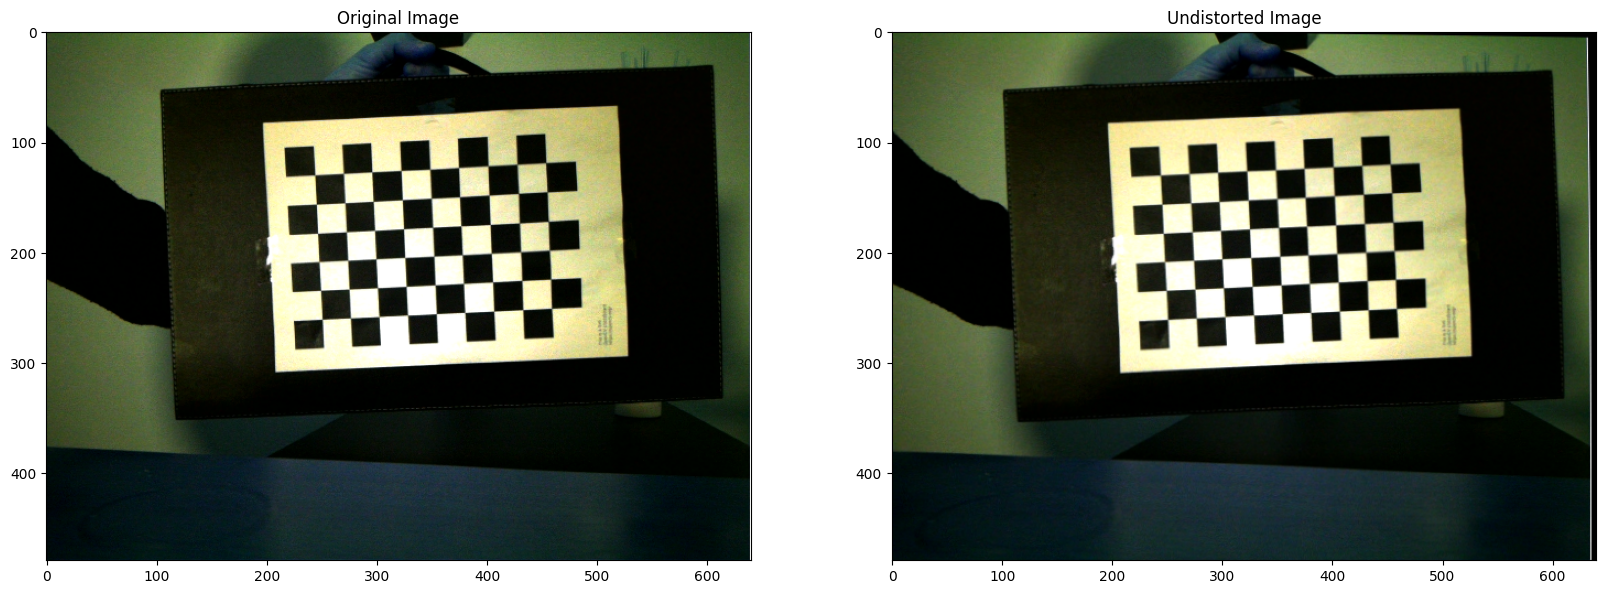

In [26]:
#TODO: Undistort the image
img =cv2.imread(calibration_images[0])
undistorted =cv2.undistort(img, mtx, dist, None)

## TODO2: Display the image before and after distortion
f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,10))
ax0.imshow(img)
ax0.set_title("Original Image")
ax1.imshow(undistorted)
ax1.set_title("Undistorted Image")
plt.show()

# Step 2 - Stereo Camera Calibration

We are now ready for stereo calibration.
The output we'll get:


*   Intrinsic and Extrinsic parameters for both cameras

You will also get some parameters we'll use for Depth Perception.

*   Disparity to Depth Map
*   Fundamental And Essential Matrices
*   Projection Matrix
*   Other matrices

These will be explained in Part III - Building a 3D System

## Install Stereo Vision Library and Import some we'll need

In [ ]:
!pip3 install stereovision

  Created wheel for stereovision: filename=StereoVision-1.0.4-cp36-none-any.whl size=38327 sha256=2824fb2c6c8f06eb2d5b660c843fef7a61cf4a2b024096bd7d55b2eeec181f50
  Stored in directory: /root/.cache/pip/wheels/9f/b7/7b/ec17df273a6505fc5a0b1250a2fc90b8fd6507a0b45e429e5d
Successfully built stereovision


In [ ]:
from stereovision.calibration import StereoCalibrator
from stereovision.calibration import StereoCalibration
from stereovision.exceptions import ChessboardNotFoundError

## Follow the code from the MIPI Camera Software


*   Calibration: https://github.com/erget/StereoVision/blob/master/stereovision/calibration.py
*   Script in the Raspberry Pi: https://github.com/ArduCAM/MIPI_Camera/blob/master/RPI/stereo_depth_demo/4_calibration.py



In [ ]:
## These have been defined earlier.
img_shape = (640,480)
rows = 6
columns = 9
square_size = 2.4

# TODO: Call the Stereo Calibrator Object
calibrator =

# Define an empty counter and your number of images
counter = 0
total_photos= 30

# Call the get_corners function
# Warning, on Colab, it's better not to use cv2.imshow(). Therefore, set the last parameter for add_corners as False

while counter != total_photos:
    counter += 1
    print ('Import pair No ' + str(counter))
    leftName = 'Image Pairs/pairs/left_'+str(counter).zfill(2)+'.png'
    rightName = 'Image Pairs/pairs/right_'+str(counter).zfill(2)+'.png'
    imgLeft = cv2.imread(leftName,1)
    imgRight = cv2.imread(rightName,1)
    if os.path.isfile(leftName) and os.path.isfile(rightName):
        try:
            #TODO: Get corners and add them to the calibrator object
print ('End cycle')

### Great! Now, let's calibrate the cameras

In [ ]:
# TODO: Call Calibrate_cameras() and print the results
print ('Starting calibration... It can take several minutes!')
calibration =
print ('Calibration complete!')

print(calibration)

And now let's save our parameters:

In [ ]:
calibration.export('Image Pairs/calib_result')

### Now try to undistort the image (with the default parameters)

In [ ]:
# TODO: Rectify the images
rectified_pair =

# TODO2: Show the rectified left and right images
f, (ax0, ax1)= plt.subplots(1,2, figsize=(20,10))
ax0.imshow(imgLeft)
ax0.set_title("Left Image")
ax1.imshow(rectified_pair[0])
ax1.set_title("Rectified Left Image")
plt.show()
f, (ax2, ax3)= plt.subplots(1,2, figsize=(20,10))
ax2.imshow(imgRight)
ax2.set_title("Right Image")
ax3.imshow(rectified_pair[1])
ax3.set_title("Rectified Right Image")
plt.show()

### 😕😕😕 We need to use the Flags; but they're inside the function and cannot be changed; as you can see here: https://github.com/erget/StereoVision/blob/f09d67140e8164969ae3458fc4df658fbbf3649b/stereovision/calibration.py#L218

In [ ]:
## TODO: Rewrite the calibrate_cameras function with the desired FLAGS
## Watch this: https://docs.opencv.org/4.1.2/d9/d0c/group__calib3d.html#ga91018d80e2a93ade37539f01e6f07de5 and choose YOUR openCV version

#print(cv2.__version__) # to know your version

def calibrate_cameras(calibrator):
        """Calibrate cameras based on found chessboard corners."""
        criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)

        flags = #TODO: Pick your flags

        calib = StereoCalibration()
        # MAKE SURE THE FUNCTION CALL IS CORRECT
        (retval, calib.cam_mats["left"], calib.dist_coefs["left"], calib.cam_mats["right"], calib.dist_coefs["right"],
        calib.rot_mat, calib.trans_vec, calib.e_mat, calib.f_mat) = cv2.stereoCalibrate(calibrator.object_points,
                                            calibrator.image_points["left"],
                                            calibrator.image_points["right"],calib.cam_mats["left"],
                                            calib.dist_coefs["left"],
                                            calib.cam_mats["right"],
                                            calib.dist_coefs["right"],calibrator.image_size,calib.rot_mat,
                                            calib.trans_vec,
                                            calib.e_mat,
                                            calib.f_mat,
                                            flags, criteria)

        (calib.rect_trans["left"], calib.rect_trans["right"],
         calib.proj_mats["left"], calib.proj_mats["right"],
         calib.disp_to_depth_mat, calib.valid_boxes["left"],
         calib.valid_boxes["right"]) = cv2.stereoRectify(calib.cam_mats["left"],
                                                      calib.dist_coefs["left"],
                                                      calib.cam_mats["right"],
                                                      calib.dist_coefs["right"],
                                                      calibrator.image_size,
                                                      calib.rot_mat,
                                                      calib.trans_vec,
                                                      flags=0)
        for side in ("left", "right"):
            (calib.undistortion_map[side],
             calib.rectification_map[side]) = cv2.initUndistortRectifyMap(
                                                        calib.cam_mats[side],
                                                        calib.dist_coefs[side],
                                                        calib.rect_trans[side],
                                                        calib.proj_mats[side],
                                                        calibrator.image_size,
                                                        cv2.CV_32FC1)
        # This is replaced because my results were always bad. Estimates are
        # taken from the OpenCV samples.
        width, height = calibrator.image_size
        focal_length = 0.8 * width
        calib.disp_to_depth_mat = np.float32([[1, 0, 0, -0.5 * width],
                                              [0, -1, 0, 0.5 * height],
                                              [0, 0, 0, -focal_length],
                                              [0, 0, 1, 0]])
        return calib

In [ ]:
## TODO: Calibrate again, and compare
print ('Starting calibration... It can take several minutes!')
result_calib = calibrate_cameras(calibrator)
print ('Calibration complete!')

print(result_calib)

### Finally, let's rectify again

In [ ]:
# TODO: Rectify the images
rectified_pair = result_calib.rectify((imgLeft, imgRight))

# TODO2: Show the rectified left and right images
f, (ax0, ax1)= plt.subplots(1,2, figsize=(20,10))
ax0.imshow(imgLeft)
ax0.set_title("Left Image")
ax1.imshow(rectified_pair[0])
ax1.set_title("Rectified Left Image")
plt.show()
f, (ax2, ax3)= plt.subplots(1,2, figsize=(20,10))
ax2.imshow(imgRight)
ax2.set_title("Right Image")
ax3.imshow(rectified_pair[1])
ax3.set_title("Rectified Right Image")
plt.show()

# Calibration parameters obtained using the MIPI Camera Software

In [ ]:
f_mat = np.load("Image Pairs/calib_result/f_mat.npy")
e_mat = np.load("Image Pairs/calib_result/e_mat.npy")
cam_mats_right = np.load("Image Pairs/calib_result/cam_mats_right.npy")
cam_mats_left = np.load("Image Pairs/calib_result/cam_mats_left.npy")
disp_to_depth_mat = np.load("Image Pairs/calib_result/disp_to_depth_mat.npy")
dist_coefs_left = np.load("Image Pairs/calib_result/dist_coefs_left.npy")
dist_coefs_right = np.load("Image Pairs/calib_result/dist_coefs_right.npy")
proj_mats_left = np.load("Image Pairs/calib_result/proj_mats_left.npy")
proj_mats_right = np.load("Image Pairs/calib_result/proj_mats_right.npy")
rect_trans_left = np.load("Image Pairs/calib_result/rect_trans_left.npy")
rect_trans_right = np.load("Image Pairs/calib_result/rect_trans_right.npy")
rectification_map_left = np.load("Image Pairs/calib_result/rectification_map_left.npy")
rectification_map_right = np.load("Image Pairs/calib_result/rectification_map_right.npy")
rot_mat = np.load("Image Pairs/calib_result/rot_mat.npy")
trans_vec = np.load("Image Pairs/calib_result/trans_vec.npy")
undistortion_map_left = np.load("Image Pairs/calib_result/undistortion_map_left.npy")
undistortion_map_right = np.load("Image Pairs/calib_result/undistortion_map_right.npy")
valid_boxes_left = np.load("Image Pairs/calib_result/valid_boxes_left.npy")
valid_boxes_right = np.load("Image Pairs/calib_result/valid_boxes_right.npy")

print("Fundamental Matrix")
print(f_mat)
print("Essential Matrix")
print(e_mat)
print("Camera Matrix Left/Right")
print(cam_mats_left)
print(cam_mats_right)
print("Rotation Matrix")
print(rot_mat)
print("Translation Vector")
print(trans_vec)
print("Disparity to Depth Matrix")
print(disp_to_depth_mat)
print("Distortion Coefficients Left/Right")
print(dist_coefs_left)
print(dist_coefs_right)
print("Projection Matrix Left/Right")
print(proj_mats_left)
print(proj_mats_right)
print("Rectification Translation Left/Right")
print(rect_trans_left)
print(rect_trans_right)
print("Rectification Map Left/Right")
print(rectification_map_left)
print(rectification_map_right)
print("Undistortion Map Left/Right")
print(undistortion_map_left)
print(undistortion_map_right)
print("Valid Boxes Left/Right")
print(valid_boxes_right)
print(valid_boxes_left)

Fundamental Matrix
[[-3.95129778e-08  1.82893710e-05 -6.22468354e-03]
 [-1.31819337e-05  1.30003489e-06  9.91831320e-02]
 [ 4.64089222e-03 -1.01162231e-01  1.00000000e+00]]
Essential Matrix
[[-1.81027383e-03  8.37921403e-01 -1.44427002e-01]
 [-6.03925874e-01  5.95606627e-02  7.74216445e+00]
 [ 1.16160622e-01 -7.72063922e+00  5.34773705e-02]]
Camera Matrix Left/Right
[[564.31617921   0.         313.83238536]
 [  0.         564.31617921 243.75486581]
 [  0.           0.           1.        ]]
[[564.31617921   0.         314.33001454]
 [  0.         564.31617921 242.58040019]
 [  0.           0.           1.        ]]
Rotation Matrix
[[ 0.99953395 -0.0030755  -0.03037146]
 [ 0.00284984  0.99996803 -0.00747048]
 [ 0.03039346  0.00738044  0.99951076]]
Translation Vector
[[-7.72046088]
 [-0.13822713]
 [-0.8389684 ]]
Disparity to Depth Matrix
[[   1.    0.    0. -320.]
 [   0.   -1.    0.  240.]
 [   0.    0.    0. -512.]
 [   0.    0.    1.    0.]]
Distortion Coefficients Left/Right
[[-0.013